In [1]:
import numpy as np
import cv2
import tensorflow as tf
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt

In [2]:
#tf.config.run_functions_eagerly(True)

# Rigid Transformation

In [3]:
def load_image(path,target_size=None):
    image = cv2.imread(path)
    if target_size:
        image = cv2.resize(image,target_size)
    image = image / 255
    return image

def show_images(images):
    """ Takes a list of images and output a horizontal concatenated version of them. """
    full_image = np.concatenate(images, axis=1)
    cv2.imshow("Full_Image",full_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
def create_grid(width,height,num_batch):
    """ Create a 2d grid which is num_batch*list of indices of pixels. 
    
        All the credits for the work goes to https://github.com/kevinzakka
    """
    # Create normalized 2d grid
    x = np.linspace(-1, 1, width)
    y = np.linspace(-1, 1, height)
    x_t, y_t = np.meshgrid(x, y)
    # reshape to (xt, yt, 1) to allow translation
    ones = np.ones(np.prod(x_t.shape))
    sampling_grid = np.vstack([x_t.flatten(), y_t.flatten(), ones])
    # repeat grid num_batch times
    sampling_grid = np.resize(sampling_grid, (num_batch, 3, height*width))
    return sampling_grid

def apply_transform(M,input_image,sampling_grid,num_batch,H,W):
    """ Apply a rigid transform to the input image
    
        All the credits for the work goes to https://github.com/kevinzakka
    """
    #print(f"Input shapes : {M.shape,input_image.shape,sampling_grid.shape,num_batch,H,W}")
    # transform the sampling grid i.e. batch multiply
    batch_grids = np.matmul(M, sampling_grid)
    # batch grid has shape (num_batch, 2, H*W)

    # reshape to (num_batch, height, width, 2)
    batch_grids = batch_grids.reshape(num_batch, 2, H, W)
    batch_grids = np.moveaxis(batch_grids, 1, -1)
    x_s = batch_grids[:, :, :, 0:1].squeeze()
    y_s = batch_grids[:, :, :, 1:2].squeeze()
    # rescale x and y to [0, W/H]
    x = ((x_s + 1.) * W) * 0.5
    y = ((y_s + 1.) * H) * 0.5
    # grab 4 nearest corner points for each (x_i, y_i)
    x0 = np.floor(x).astype(np.int64)
    x1 = x0 + 1
    y0 = np.floor(y).astype(np.int64)
    y1 = y0 + 1
    # make sure it's inside img range [0, H] or [0, W]
    x0 = np.clip(x0, 0, W-1)
    x1 = np.clip(x1, 0, W-1)
    y0 = np.clip(y0, 0, H-1)
    y1 = np.clip(y1, 0, H-1)
    # make sure it's inside img range [0, H] or [0, W]
    x0 = np.clip(x0, 0, W-1)
    x1 = np.clip(x1, 0, W-1)
    y0 = np.clip(y0, 0, H-1)
    y1 = np.clip(y1, 0, H-1)
    # look up pixel values at corner coords
    Ia = input_image[np.arange(num_batch)[:,None,None], y0, x0]
    Ib = input_image[np.arange(num_batch)[:,None,None], y1, x0]
    Ic = input_image[np.arange(num_batch)[:,None,None], y0, x1]
    Id = input_image[np.arange(num_batch)[:,None,None], y1, x1]
    # calculate deltas
    wa = (x1-x) * (y1-y)
    wb = (x1-x) * (y-y0)
    wc = (x-x0) * (y1-y)
    wd = (x-x0) * (y-y0)
    # add dimension for addition
    wa = np.expand_dims(wa, axis=3)
    wb = np.expand_dims(wb, axis=3)
    wc = np.expand_dims(wc, axis=3)
    wd = np.expand_dims(wd, axis=3)
    # compute output
    out = wa*Ia + wb*Ib + wc*Ic + wd*Id
    return out

### Preview

In [4]:
# params
DIMS = (400, 400)
CAT1 = 'data/normal/0/0.jpg'
CAT2 = 'data/normal/1/0.jpg'

# load both cat images
img1 = load_image(CAT1,(400,400))
img2 = load_image(CAT2,(400,400))

# concat into tensor of shape (2, 400, 400, 3)
input_img = np.stack([img1[:,:,1], img2[:,:,1]], axis=0) # keep only a color to emulate gray scale
input_img = input_img[:,:,:,np.newaxis]
# dimension sanity check
print("Input Img Shape: {}".format(input_img.shape))

Input Img Shape: (2, 400, 400, 1)


In [5]:
# grab shape
num_batch, H, W, C = input_img.shape

# initialize M to a transform
# M = np.array([[1., 0., 0.], [0., 1., 0.]]) # identity 
M = np.array([[tf.cos(np.pi/16),-tf.sin(np.pi/16),0],
              [tf.sin(np.pi/16),tf.cos(np.pi/16),0]])# small rotation

# repeat num_batch times
M = np.resize(M, (num_batch, 2, 3))

In [6]:
sampling_grid = create_grid(W,H,num_batch)
out = apply_transform(M,input_img,sampling_grid,num_batch,H,W)
show_images([out[1]])

# Transformation TF

In [6]:
# @tf.function
def regular_grid_2d(height, width):
    x = tf.linspace(-1.0, 1.0, width)  # shape (W, )
    y = tf.linspace(-1.0, 1.0, height)  # shape (H, )

    X, Y = tf.meshgrid(x, y)  # shape (H, W), both X and Y

    grid = tf.stack([X, Y], axis=-1)
    return grid


# @tf.function
def grid_sample_2d(moving, grid):
    nb, nh, nw, nc = tf.shape(moving)

    x = grid[..., 0]  # shape (N, H, W)
    y = grid[..., 1]
    x = tf.cast(x, 'float32')
    y = tf.cast(y, 'float32')

    # Scale x and y from [-1.0, 1.0] to [0, W] and [0, H] respectively.
    x = (x + 1.0) * 0.5 * tf.cast(nw-1, 'float32')
    y = (y + 1.0) * 0.5 * tf.cast(nh-1, 'float32')

    y_max = tf.cast(nh - 1, 'int32')
    x_max = tf.cast(nw - 1, 'int32')
    zero = tf.constant(0, 'int32')

    # The value at (x, y) is a weighted average of the values at the
    # four nearest integer locations: (x0, y0), (x1, y0), (x0, y1) and
    # (x1, y1) where x0 = floor(x), x1 = ceil(x).
    x0 = tf.cast(tf.floor(x), 'int32')
    x1 = x0 + 1
    y0 = tf.cast(tf.floor(y), 'int32')
    y1 = y0 + 1

    # Make sure indices are within the boundaries of the image.
    x0 = tf.clip_by_value(x0, zero, x_max)
    x1 = tf.clip_by_value(x1, zero, x_max)
    y0 = tf.clip_by_value(y0, zero, y_max)
    y1 = tf.clip_by_value(y1, zero, y_max)

    # Collect indices of the four corners.
    b = tf.ones_like(x0) * tf.reshape(tf.range(nb), [nb, 1, 1])
    idx_a = tf.stack([b, y0, x0], axis=-1)  # all top-left corners
    idx_b = tf.stack([b, y1, x0], axis=-1)  # all bottom-left corners
    idx_c = tf.stack([b, y0, x1], axis=-1)  # all top-right corners
    idx_d = tf.stack([b, y1, x1], axis=-1)  # all bottom-right corners
    # shape (N, H, W, 3)

    # Collect values at the corners.
    moving_a = tf.gather_nd(moving, idx_a)  # all top-left values
    moving_b = tf.gather_nd(moving, idx_b)  # all bottom-left values
    moving_c = tf.gather_nd(moving, idx_c)  # all top-right values
    moving_d = tf.gather_nd(moving, idx_d)  # all bottom-right values
    # shape (N, H, W, C)
    

    x0_f = tf.cast(x0, 'float32')
    x1_f = tf.cast(x1, 'float32')
    y0_f = tf.cast(y0, 'float32')
    y1_f = tf.cast(y1, 'float32')

    # Calculate the weights.
    wa = tf.expand_dims((x1_f - x) * (y1_f - y), axis=-1)
    wb = tf.expand_dims((x1_f - x) * (y - y0_f), axis=-1)
    wc = tf.expand_dims((x - x0_f) * (y1_f - y), axis=-1)
    wd = tf.expand_dims((x - x0_f) * (y - y0_f), axis=-1)
    
    # Calculate the weighted sum.
    moved = tf.add_n([tf.multiply(wa,moving_a), tf.multiply(wb,moving_b), tf.multiply(wc,moving_c),
                      tf.multiply(wd,moving_d)])
    return moved

In [7]:
# @tf.function
def grid_transform(theta, grid):
    # todo grid has nb
    nb = tf.shape(theta)[0]
    nh, nw, _ = tf.shape(grid)
    x = grid[..., 0]  # h,w
    y = grid[..., 1]

    x_flat = tf.reshape(x, shape=[-1]) 
    y_flat = tf.reshape(y, shape=[-1])
    ones = tf.ones_like(x_flat)
    grid_flat = tf.stack([x_flat, y_flat, ones])
    grid_flat = tf.expand_dims(grid_flat, axis=0)
    grid_flat = tf.tile(grid_flat, tf.stack([nb, 1, 1]))

    theta = tf.cast(theta, 'float32')
    grid_flat = tf.cast(grid_flat, 'float32')

    grid_new = tf.matmul(theta, grid_flat)  # n, 2, h*w
    grid_new = tf.transpose(grid_new, perm=[0,2,1])
    grid_new = tf.reshape(grid_new, [nb, nh, nw, 2])

    return grid_new

In [8]:
theta = tf.constant([[0,1,0],[1,0,0]])

transform = tf.constant(input_img)
transform = tf.cast(transform, "float32")

grid = regular_grid_2d(W,H)
grid_new = grid_transform(theta, grid)
grid_new = tf.clip_by_value(grid_new, -1, 1)
out = grid_sample_2d(transform, grid_new)
show_images([out[1]])

#  Losses

In [9]:
@tf.function
def mse_loss(static, moving):
    loss = tf.reduce_mean(tf.square(moving - static))  
    return loss

# Model Definition

In [10]:
def deep_net(input_shape=(32,32,1)):
    moving = layers.Input(shape=input_shape, name='moving')
    static = layers.Input(shape=input_shape, name='static')
    # Vision Tower Moving
    x_moving_skip = layers.Conv2D(64,kernel_size=3,strides=1,padding="same",activation="relu")(moving)
    x_moving = layers.Conv2D(64,kernel_size=3,strides=1,padding="same",activation="relu")(x_moving_skip)
    x_moving = layers.Add()([x_moving_skip,x_moving]) # skip connection
    # Vision Tower Static
    x_static_skip = layers.Conv2D(64,kernel_size=3,strides=1,padding="same",activation="relu")(static)
    x_static = layers.Conv2D(64,kernel_size=3,strides=1,padding="same",activation="relu")(x_static_skip)
    x_static = layers.Add()([x_static_skip,x_static]) # skip connection
    print(f"Shape of output of vision towers : {x_static.shape},{x_moving.shape}")
    # Merge both inputs into 1D array
    x = layers.concatenate([x_moving,x_static],axis=-1,name="BipBoup")
    x = layers.Flatten()(x)
    print(f"Shape of flatten input : {x.shape}")
    # Dropout to add regularization
    x = layers.Dropout(rate=0.5)(x)
    # Dense layers
    x = layers.Dense(units=64,activation="relu")(x)
    x = layers.Dense(units=64,activation="relu")(x)
    x = layers.Dense(units=3,activation="relu")(x)
    print(f"Neural Net output shape : {x.shape}")
    theta = x[:,0]
    rotation_matrix = tf.stack([tf.cos(theta),
                              -tf.sin(theta),  
                               tf.sin(theta),
                               tf.cos(theta)],axis=1)
    rotation_matrix = tf.reshape(rotation_matrix, (-1,2,2))
    print(f"Shape of rotation matrix {rotation_matrix.shape}")
    translation_vectors = x[:,1:]
    M = tf.concat([rotation_matrix,translation_vectors[:,:,np.newaxis]],axis=2)
    print(f"Final tranformation matrix shape : {M.shape}")
    # Move the image according to learned transformation
    grid = regular_grid_2d(input_shape[0],input_shape[1])
    grid_new = grid_transform(M, grid)
    grid_new = tf.clip_by_value(grid_new, -1, 1)
    moved = grid_sample_2d(moving, grid_new)
    # Final Model
    model = tf.keras.Model(inputs=[static,moving],outputs=moved,name="Simple_DeepNet")
    return model

In [11]:
deep_net();

Shape of output of vision towers : (None, 32, 32, 64),(None, 32, 32, 64)
Shape of flatten input : (None, 131072)
Neural Net output shape : (None, 3)
Shape of rotation matrix (None, 2, 2)
Final tranformation matrix shape : (None, 2, 3)


# Model Training 

In [12]:
@tf.function
def train_step(model,moving,static,criterion,optimizer):
    num_batch, W, H, C = tf.keras.backend.int_shape(moving)  # moving.shape
    # Same static
    multiples = tf.constant([num_batch, 1, 1, 1], tf.int32)
    static = tf.tile(static, multiples)
    # Define Gradient Tape
    with tf.GradientTape() as tape:
        # Get transformation matrices M
        #print(moving.shape, static.shape, "train")
        moved = model({'moving': moving, 'static': static})
        # Compute the loss
        loss = criterion(moved,static)
    # Compute gradients.
    grads = tape.gradient(loss, model.trainable_variables)
    # Update the trainable parameters.
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [13]:
@tf.function
def test_step(model, moving, static, criterion):
    nb, nh, nw, nc = tf.keras.backend.int_shape(moving)  # moving.shape

    # Repeat the static image along the batch dim.
    multiples = tf.constant([nb, 1, 1, 1], tf.int32)
    static = tf.tile(static, multiples)

    # Get the deformation field.
    # inputs = tf.concat([moving, static], axis=-1)
    moved = model({'moving': moving, 'static': static}, training=False)

    # Compute the loss.
    loss = criterion(moved, static)
    return loss

# Data Loader

### MNIST

In [14]:
def load_data(label=2):

    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    # Discard digits which are not equal to label.
    ids_train = np.where(y_train == label)
    ids_test = np.where(y_test == label)

    x_train = x_train[ids_train]
    x_test = x_test[ids_test]

    # Scale the image to [0, 1] range.
    x_train = x_train.astype(np.float32) / 255.0
    x_test = x_test.astype(np.float32) / 255.0

    # Add the channel dim at the end. (N, H, W) --> (N, H, W, 1)
    x_train = x_train[..., None]
    x_test = x_test[..., None]

    # Resize images from (28, 28) to (32, 32).
    x_train = tf.image.resize(x_train, (32, 32))
    x_test = tf.image.resize(x_test, (32, 32))
    return x_train, x_test

# Plot images

In [15]:
def plot_images(model, moving, static):
    nb, nh, nw, nc = moving.shape

    # Repeat the static image along the batch dim.
    multiples = tf.constant([nb, 1, 1, 1], tf.int32)
    static = tf.tile(static, multiples)

    moved = model({'moving': moving, 'static': static}, training=False)

    # Convert the tensors to 8-bit images.
    moved = moved.numpy().squeeze(axis=-1) * 255.0
    moved = moved.astype(np.uint8)
    moving = moving.numpy().squeeze(axis=-1) * 255.0
    moving = moving.astype(np.uint8)
    static = static.numpy().squeeze(axis=-1) * 255.0
    static = static.astype(np.uint8)

    # Plot images.
    fig = plt.figure(figsize=(3 * 1.7, nb * 1.7))
    titles_list = ['Static', 'Moved', 'Moving']
    images_list = [static, moved, moving]
    for i in range(nb):
        for j in range(3):
            ax = fig.add_subplot(nb, 3, i * 3 + j + 1)
            if i == 0:
                ax.set_title(titles_list[j], fontsize=20)
            ax.set_axis_off()
            ax.imshow(images_list[j][i], cmap='gray')

    plt.tight_layout()
    plt.show()

# Pipeline

In [16]:
def main(args):

    # Load preprocessed training and testing data.
    x_train, x_test = load_data(label=args.label)

    # Randomly select an image as the static image from the test set.
    idx = np.random.randint(x_test.shape[0])
    static = tf.expand_dims(x_test[idx], axis=0)
    print(f"static image chosen = {idx}")

    # Select some images from the test set to show sample results.
    ids = tf.constant(np.random.choice(x_test.shape[0], replace=False,
                                       size=args.num_samples))
    x_sample = tf.gather(x_test, ids)

    # Shuffle and batch the dataset.
    from_tensor_slices = tf.data.Dataset.from_tensor_slices
    x_train = from_tensor_slices(x_train).shuffle(10000).batch(args.batch_size)
    x_test = from_tensor_slices(x_test).shuffle(10000).batch(args.batch_size)

    # Create a model instance.
    model = deep_net(input_shape=(32, 32, 1))

    # Select optimizer and loss function.
    optimizer = tf.keras.optimizers.SGD(learning_rate=args.lr)
    criterion = mse_loss  

    # Define the metrics to track training and testing losses.
    m_train = tf.keras.metrics.Mean(name='loss_train')
    m_test = tf.keras.metrics.Mean(name='loss_test')

    # Train and evaluate the model.
    for epoch in range(args.epochs):
        m_train.reset_states()
        m_test.reset_states()
        for i, moving in enumerate(x_train):
            #static = tf.repeat(static_base, moving.shape[0], axis=0)
            #print(static.shape, moving.shape, "main", i)
            loss_train = train_step(model, moving, static, criterion,
                                    optimizer)
            m_train.update_state(loss_train)

        for i, moving in enumerate(x_test):
            loss_test = test_step(model, moving, static, criterion)
            m_test.update_state(loss_test)

        print('Epoch: %3d/%d\tTrain Loss: %.6f\tTest Loss: %.6f'
              % (epoch + 1, args.epochs, m_train.result(), m_test.result()))
    print('\n')

    # Show sample results.
    plot_images(model, x_sample, static)

    # Save the trained model.
    if args.save_model:
        model.save('saved_models/simple_cnn')

static image chosen = 415
Shape of output of vision towers : (None, 32, 32, 64),(None, 32, 32, 64)
Shape of flatten input : (None, 131072)
Neural Net output shape : (None, 3)
Shape of rotation matrix (None, 2, 2)
Final tranformation matrix shape : (None, 2, 3)
Epoch:   1/20	Train Loss: 0.019670	Test Loss: 0.018185
Epoch:   2/20	Train Loss: 0.017508	Test Loss: 0.018041
Epoch:   3/20	Train Loss: 0.017397	Test Loss: 0.017988
Epoch:   4/20	Train Loss: 0.017335	Test Loss: 0.017946
Epoch:   5/20	Train Loss: 0.017301	Test Loss: 0.017930
Epoch:   6/20	Train Loss: 0.017279	Test Loss: 0.017926
Epoch:   7/20	Train Loss: 0.017253	Test Loss: 0.017907
Epoch:   8/20	Train Loss: 0.017239	Test Loss: 0.017895
Epoch:   9/20	Train Loss: 0.017229	Test Loss: 0.017893
Epoch:  10/20	Train Loss: 0.017218	Test Loss: 0.017949
Epoch:  11/20	Train Loss: 0.017206	Test Loss: 0.017876
Epoch:  12/20	Train Loss: 0.017198	Test Loss: 0.017868
Epoch:  13/20	Train Loss: 0.017189	Test Loss: 0.017872
Epoch:  14/20	Train Loss

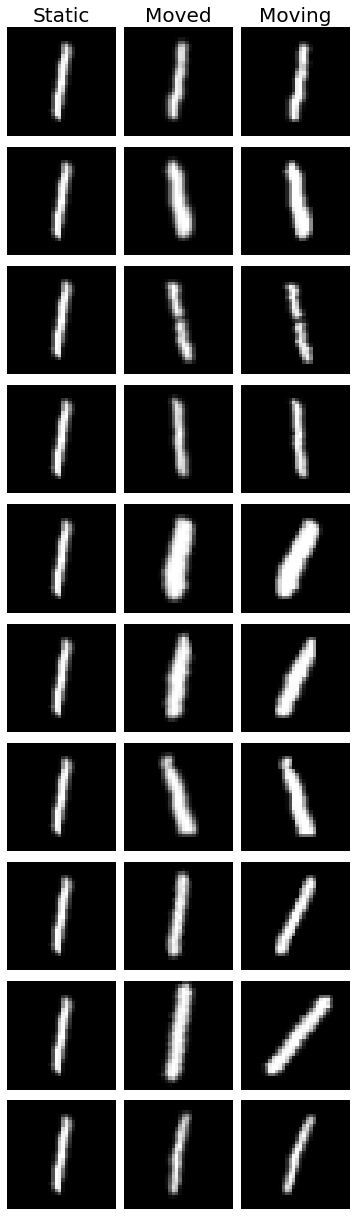

In [17]:
if __name__ == '__main__':

    class Args():
        batch_size = 8
        epochs = 20
        lr = 0.004
        label = 1  # which digit images to train on?
        num_samples =  10 # number of sample results to show
        save_model = False
    
    args = Args()
    main(args)